In [107]:
import json
import logging
import graph_tool as gt
import numpy as np

from rdkit import Chem
from func_timeout import func_timeout, FunctionTimedOut
from graph_tool.topology import max_cliques

class CorrespondenceGraph():
    '''
    Build the correspondence matrix of putative atom pairings, from which to determine the maximal clique (comprising the MCS). 
    '''
    
    def __init__(self):

        # inherit from graph_tool.Graph
        #super().__init__(self)
        pass
    
    def build(self, mol1, mol2, strictness, correspondence):
        '''
        Build the correspondence graph.
        
        Each atomic pairing is assigned a providional score, from 0 (most different) to 8000 (identical). 
        This pairwise score is appended to the tuple representing each node, following the atomic indices.
        '''
        self._g = gt.Graph()
        
        # store strictness for scoring
        self._strict = strictness * 1000
        self._corr = correspondence
        
        # calculate distance matrices
        dmat1 = Chem.GetDistanceMatrix(mol1)
        dmat2 = Chem.GetDistanceMatrix(mol2)
        
        # extract propery in such a way error is not thrown on comparison
        def getCIPCode(atom):
            try: return atom.GetProp('_CIPCode')
            except KeyError: return None

        # iterate over all potential atom-atom pairings
        self._nodedata = []
        for atom1 in mol1.GetAtoms():
            for atom2 in mol2.GetAtoms():

                # set penalties - [penalty] strikes and you're out!
                # TODO: move atomic properies to graph 
                matches = 0
                if atom1.GetAtomicNum() == atom2.GetAtomicNum(): matches += 1000
                if atom1.GetImplicitValence() == atom2.GetImplicitValence(): matches += 1000
                if atom1.GetExplicitValence() == atom2.GetExplicitValence(): matches += 1000
                if atom1.GetFormalCharge() == atom2.GetFormalCharge(): matches += 1000
                if atom1.GetIsAromatic() == atom2.GetIsAromatic(): matches += 1000
                if atom1.GetDegree() == atom2.GetDegree(): matches += 1000
                if atom1.IsInRing() == atom2.IsInRing(): matches += 1000
                if getCIPCode(atom1) == getCIPCode(atom2): matches += 1000

                # accept node with greater than specified match level
                mapping = (atom1.GetIdx(), atom2.GetIdx())
                if matches > self._strict: 
                    self._g.add_vertex() #, weight=matches)  
                    self._nodedata.append({'map': mapping, 'weight': matches})

        # create correspondence graph edges
        self._edgedata = []
        for vert1 in self._g.vertices():
            self._edgedata.append([])
            for vert2 in self._g.vertices():
                self._edgedata[int(vert1)].append({})
                
                #if int(vert1) < int(vert2): continue
                
                map1 = self._nodedata[int(vert1)]['map']
                map2 = self._nodedata[int(vert2)]['map']

                # ensure any given atom is not mapped twice in a clique
                if map1[0] == map2[0] or map1[1] == map2[1]: continue

                # test if criteria are met for correspondence
                correspondence = abs(dmat1[map1[0]][map2[0]] - dmat2[map1[1]][map2[1]])
                #correspondence1 = np.mean(abs(dmat1[map1[0]] - dmat1[map2[0]]))
                #correspondence2 = np.mean(abs(dmat2[map1[1]] - dmat2[map2[1]]))
                #correspondence = abs(correspondence1 - correspondence2)
                if correspondence < self._corr: 
                    self._g.add_edge(vert1, vert2) #, weight=int(np.floor(1000/((1+correspondence)))))
                    self._edgedata[int(vert1)][int(vert2)] = {'map': (map1, map2), 'weight': int(np.floor(1000/((1+correspondence))))}

    def solve(self, solver, timeout=600):
        '''
        Enumerate cliques and rescore:
            solver=find_cliques - analyse maximal cliques only (default)
            solver=find_cliques_recursive - (recursively) analyse maximal cliques only
            solver=enumerate_all_cliques - analyse all cliques (not recommended for performance reasons)
        
        Returns:
            bestclique - the best scoring clique (including partially matching atoms, and used to derive reaction mappings)
            bestmcs - the subset of bestclique containing exact chemical matches only (to be discarded to produce the RECS)
        '''
                    
        # define function with no arguments (for use with timeout function)
        def findCliquesNoArgs(): return list(solver(self._g))
        
        # try finding cliques within [timeout] seconds
        try:
            cliques = func_timeout(timeout, findCliquesNoArgs)
            print(self._g.num_vertices(), self._g.num_edges(), len(cliques))
        except FunctionTimedOut:
            logging.warning(json.dumps({"message": "failed to find cliques in {} seconds".format(timeout)}))
            return list(), list()
        
        # score (largest cliques first)
        bestscore = -1E800
        cliques.sort(key=len, reverse=True)
        for clique in cliques:
            
            # initialize scores
            score = 0
            mcs = list(clique)
            #if 8000 * len(clique) <= bestscore: continue # score cannot be greater than clique size
                
            # iterate over the mappings identified from MCSS
            for pair in clique:
                weight = self._nodedata[pair]['weight']
                score += weight
            for map1, map2 in self._g.edges():                    
                if map1 < map2: continue
                if map1 not in clique or map2 not in clique: continue
                try: weight = self._edgedata[int(map2)][int(map1)]['weight']
                except KeyError: weight = self._edgedata[int(map1)][int(map2)]['weight']
                score += weight

            # store results if best so far
            if score > bestscore:
                bestscore = score
                bestmcs = mcs
                bestclique = clique  
                
        bestmcs = [x for x in bestclique if self._nodedata[x]['weight'] == 8000] 
        #mcs = [x for x in mcs if np.mean(mmp._graph._corrmat[x].T[bestclique]) == 1000]
        
        # replace indices with actual mappings for downstream
        bestmcs = [self._nodedata[x]['map'] for x in bestmcs] 
        bestclique = [self._nodedata[x]['map'] for x in bestclique]         
                
        # return results
        print(bestscore)
        return bestclique, bestmcs
        
class MMP():

    @staticmethod
    def __molFromSmiles(smiles: str):
        
        # parse smiles
        try: mol = Chem.MolFromSmiles(smiles)
        except: return None
            
        # add hydrogen where defining isomer
        isomerics = []
        for atom in mol.GetAtoms():
            if not atom.HasProp('_CIPCode'): continue
            isomerics.append(atom.GetIdx())
        mol = Chem.AddHs(mol, onlyOnAtoms=isomerics, explicitOnly=True)
                      
        # clear mappings and initialise radii (assume all atoms are RECS)
        for atom in mol.GetAtoms(): 
            atom.SetProp('molAtomRadius','0')
            atom.ClearProp('molAtomMapNumber')
            
        # return
        return mol
    
    def __init__(self, smiles_x: str, smiles_y: str, strictness=4, correspondence=1):
        '''
        Initialise the matched molecular pair.
        
        smiles_x: First molecule to compare.
        smiles_y: Second molecule to compare.
        strictness: Integer (1-8) to indicate how tolerant the algortitm should to be to atom-wise differences in the construction of the correspondence graph. 
            1 (slowest) purely topological comparison of structures.
            8 (fastest) atoms chemically identical to be considered part of mcss.  
        '''
        
        # canonicalise smiles
        self._smiles1 = Chem.MolToSmiles(Chem.MolFromSmiles(smiles_x))
        self._smiles2 = Chem.MolToSmiles(Chem.MolFromSmiles(smiles_y))
         
        # initialise molecules for comparison
        self._mol1 = self.__molFromSmiles(self._smiles1)
        self._mol2 = self.__molFromSmiles(self._smiles2)
        
        # intialise correspondence graph
        self._graph = CorrespondenceGraph()
        self._graph.build(self._mol1, self._mol2, strictness, correspondence)
        
        # dummy vars
        self._clique = None
        self._mcs = None
        
    def __search(self, solver):
        
        # find the MCS
        self._clique, self._mcs = self._graph.solve(solver=solver)

        # determine the % of largest molecule covered by MCS
        self._percentmcs = len(self._mcs) / max(self._mol1.GetNumAtoms(), self._mol2.GetNumAtoms())        

    def __setAtomMapNumbers(self):        
        '''
        Use the indices of the best scoring clique to define the atom mappings.
        '''

        # iterate over the mappings identified from MCSS
        for pair in self._clique:
            
            # increment the index to prevent atom mappings of 0
            mapIdx = self._clique.index(pair) + 1
            
            # map first atom and set radius to 99 (atom part of MCS)
            atom1 = self._mol1.GetAtomWithIdx(pair[0])
            atom1.SetProp('molAtomMapNumber', '%d'%mapIdx)
            print('mol1: idx {} map {}'.format(pair[0], mapIdx))
            
            # map second atom and set radius to 99 (atom part of MCS)
            atom2 = self._mol2.GetAtomWithIdx(pair[1])
            atom2.SetProp('molAtomMapNumber', '%d'%mapIdx)
            print('mol2: idx {} map {}'.format(pair[1], mapIdx))

    def __setAtomRadii(self):
        '''
        Use the atomic radii to denote which atoms are part of the MCS. By elimination, those atoms with radii of 0 will form the RECS.
        '''

        # iterate over the remaining mappings identified from MCSS
        for pair in self._mcs:
            
            # map first atom and set radius to 99 (atom part of MCS)
            atom1 = self._mol1.GetAtomWithIdx(pair[0])
            atom1.SetProp('molAtomRadius','99')
            
            # map second atom and set radius to 99 (atom part of MCS)
            atom2 = self._mol2.GetAtomWithIdx(pair[1])
            atom2.SetProp('molAtomRadius','99')

    def execute(self, radii=4, solver=max_cliques):
        '''
        solver = max_weight_clique, enumerate_all_cliques, find_cliques, find_cliques_recursive
        '''
                
        # search, mark up atom mappings and MCS/RECS split
        self.__search(solver)
        self.__setAtomMapNumbers()
        self.__setAtomRadii()
        
        # define function for elimination of MCS
        def eliminate(mol, radius):
        
            # tag atoms within 4 bonds of attachment
            toRemove = set(range(mol.GetNumAtoms()))
            for atom in mol.GetAtoms():
                if atom.GetProp('molAtomRadius') ==  '0':
                    for idx in Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom.GetIdx()):
                        envBond = mol.GetBondWithIdx(idx)
                        toRemove.discard(envBond.GetBeginAtom().GetIdx())
                        toRemove.discard(envBond.GetEndAtom().GetIdx())
                        
            # remove environment from core
            toRemove = list(toRemove)
            toRemove.sort(reverse=True)
            frag = Chem.EditableMol(mol)
            for atom in toRemove: frag.RemoveAtom(atom)
            frag = frag.GetMol()
            return frag
      
        # loop from 4 down to 1 bond radius to find smallest valid transformation
        responselist = list()
        for radius in reversed(range(radii+1)):
            
            # return list of valid transformations
            if radius == 0: return responselist
            
            # initialise response object
            response = {'smiles1': self._smiles1,
                        'smiles2': self._smiles2,
                        'percentmcs': self._percentmcs,
                        'radius': radius,
                        'valid': False}
            
            # Define reaction as SMIRKS while mappings still present
            frag1 = eliminate(self._mol1, radius)
            frag2 = eliminate(self._mol2, radius)   
            smirks = '{}>>{}'.format(Chem.MolToSmarts(Chem.AddHs(frag1)), Chem.MolToSmarts(Chem.AddHs(frag2)))
            response['smirks'] = smirks
            
            # verify 1:1 reaction
            rxn = Chem.rdChemReactions.ReactionFromSmarts(smirks)
            if rxn.GetNumReactantTemplates() != 1 or rxn.GetNumProductTemplates() != 1: 
                logging.info(json.dumps({'radius': radius, "message": "no 1:1 reaction could be generated"}))
                responselist.append(response)
                continue

            # verify derived reaction produces original 'product'
            print(smirks, self._smiles1)
            productset = rxn.RunReactants((Chem.AddHs(Chem.MolFromSmiles(self._smiles1)),))
            productlist = list()
            for product in productset:
                productlist.append('.'.join([Chem.MolToSmiles(Chem.RemoveHs(productpart)) for productpart in product]))
            if self._smiles2 not in productlist:
                logging.info(json.dumps({'radius': radius, "message": "second molecule not found amongst products enumerated from first"}))
                responselist.append(response)
                continue

            # remove mappings to yield clean fragments
            for atom in frag1.GetAtoms(): atom.ClearProp('molAtomMapNumber')
            frag1 = Chem.MolToSmiles(frag1, allHsExplicit=True)
            for atom in frag2.GetAtoms(): atom.ClearProp('molAtomMapNumber')
            frag2 = Chem.MolToSmiles(frag2, allHsExplicit=True)

            # return key response elements
            response['valid'] = True
            response['fragment1'] = frag1
            response['fragment2'] = frag2
            responselist.append(response)

In [108]:
#mmp = MMP('Cc1cccnc1', 'Cc1ccccn1', strictness=5, correspondence=99)
mmp = MMP('CC(C)NC[C@@H](O)c1ccc(O)c(O)c1', 'CC(C)NC[C@H](O)c1ccc(O)c(O)c1', strictness=5, correspondence=3)
#mmp = MMP('Cc1oc(C)cc1', 'Cc1ccc(C)cc1', strictness=5, correspondence=99)
#mmp = MMP('N1CCC1', 'N1CCNCC1', strictness=5, correspondence=2)
#mmp = MMP('Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1', 'CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C)c2)CC1', strictness=6, correspondence=3)

In [109]:
mmp.execute(solver=max_cliques)

60 1868 1122
247000
mol1: idx 0 map 1
mol2: idx 2 map 1
mol1: idx 10 map 2
mol2: idx 10 map 2
mol1: idx 1 map 3
mol2: idx 1 map 3
mol1: idx 11 map 4
mol2: idx 11 map 4
mol1: idx 2 map 5
mol2: idx 0 map 5
mol1: idx 12 map 6
mol2: idx 12 map 6
mol1: idx 3 map 7
mol2: idx 3 map 7
mol1: idx 4 map 8
mol2: idx 4 map 8
mol1: idx 13 map 9
mol2: idx 13 map 9
mol1: idx 5 map 10
mol2: idx 5 map 10
mol1: idx 6 map 11
mol2: idx 6 map 11
mol1: idx 14 map 12
mol2: idx 14 map 12
mol1: idx 7 map 13
mol2: idx 7 map 13
mol1: idx 8 map 14
mol2: idx 8 map 14
mol1: idx 15 map 15
mol2: idx 15 map 15
mol1: idx 9 map 16
mol2: idx 9 map 16
[#6:1](-[#6:3](-[#6:5](-[H])(-[H])-[H])(-[#7:7](-[#6:8](-[#6@@:10](-[#8:11]-[H])-[#6:13]1:[#6:14](:[#6:16](:[#6:2]:[#6:6](-[#8:9]-[H]):[#6:12]:1-[H])-[H])-[H])(-[H])-[H])-[H])-[H])(-[H])(-[H])-[H]>>[#6:5](-[#6:3](-[#6:1](-[H])(-[H])-[H])(-[#7:7](-[#6:8](-[#6@:10](-[#8:11]-[H])-[#6:13]1:[#6:14](:[#6:16](:[#6:2]:[#6:6](-[#8:9]-[H]):[#6:12]:1-[H])-[H])-[H])(-[H])-[H])-[H])-[H])(

[{'smiles1': 'CC(C)NC[C@@H](O)c1ccc(O)c(O)c1',
  'smiles2': 'CC(C)NC[C@H](O)c1ccc(O)c(O)c1',
  'percentmcs': 0.9375,
  'radius': 4,
  'valid': True,
  'smirks': '[#6:1](-[#6:3](-[#6:5](-[H])(-[H])-[H])(-[#7:7](-[#6:8](-[#6@@:10](-[#8:11]-[H])-[#6:13]1:[#6:14](:[#6:16](:[#6:2]:[#6:6](-[#8:9]-[H]):[#6:12]:1-[H])-[H])-[H])(-[H])-[H])-[H])-[H])(-[H])(-[H])-[H]>>[#6:5](-[#6:3](-[#6:1](-[H])(-[H])-[H])(-[#7:7](-[#6:8](-[#6@:10](-[#8:11]-[H])-[#6:13]1:[#6:14](:[#6:16](:[#6:2]:[#6:6](-[#8:9]-[H]):[#6:12]:1-[H])-[H])-[H])(-[H])-[H])-[H])-[H])(-[H])(-[H])-[H]',
  'fragment1': '[CH3][CH]([CH3])[NH][CH2][C]([OH])[c]1[cH][cH][cH][c]([OH])[cH]1',
  'fragment2': '[CH3][CH]([CH3])[NH][CH2][C]([OH])[c]1[cH][cH][cH][c]([OH])[cH]1'},
 {'smiles1': 'CC(C)NC[C@@H](O)c1ccc(O)c(O)c1',
  'smiles2': 'CC(C)NC[C@H](O)c1ccc(O)c(O)c1',
  'percentmcs': 0.9375,
  'radius': 3,
  'valid': True,
  'smirks': '[#6:3](-[#7:7](-[#6:8](-[#6@@:10](-[#8:11]-[H])-[#6:13](:[#6:14](:[#6:16]-[H])-[H]):[#6:12](:[#6:6])-[H])(-[H])-[

In [110]:
[(x, mmp._graph._nodedata[x]) for x in mmp._clique]

TypeError: list indices must be integers or slices, not tuple

In [111]:
minatoms = min(mmp._mol1.GetNumAtoms(), mmp._mol2.GetNumAtoms())
idxclique = [x for x in zip(range(minatoms), range(minatoms))]
[(mmp._graph._nodedata.index(x), x) for x in mmp._graph._nodedata if x['map'] in idxclique]

[(0, {'map': (0, 0), 'weight': 8000}),
 (6, {'map': (1, 1), 'weight': 8000}),
 (8, {'map': (2, 2), 'weight': 8000}),
 (13, {'map': (3, 3), 'weight': 8000}),
 (16, {'map': (4, 4), 'weight': 8000}),
 (17, {'map': (5, 5), 'weight': 7000}),
 (20, {'map': (6, 6), 'weight': 8000}),
 (24, {'map': (7, 7), 'weight': 8000}),
 (27, {'map': (8, 8), 'weight': 8000}),
 (31, {'map': (9, 9), 'weight': 8000}),
 (34, {'map': (10, 10), 'weight': 8000}),
 (39, {'map': (11, 11), 'weight': 8000}),
 (44, {'map': (12, 12), 'weight': 8000}),
 (49, {'map': (13, 13), 'weight': 8000}),
 (53, {'map': (14, 14), 'weight': 8000}),
 (59, {'map': (15, 15), 'weight': 8000})]

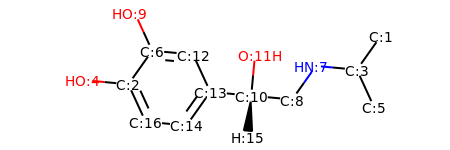

In [112]:
mmp._mol1

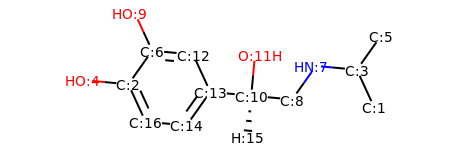

In [113]:
mmp._mol2

In [114]:
[((int(e1), int(e2)), mmp._graph._edgedata[int(e1)][int(e2)]['weight']) 
 for e1, e2 in mmp._graph._g.edges() 
 if (e1, e2) in ((x, y) for x in mmp._clique for y in mmp._clique)]

[]

In [ ]:
[((int(e1), int(e2)), mmp._graph._edgedata[int(e1)][int(e2)]['weight']) 
 for e1, e2 in mmp._graph._g.edges()
 if mmp._graph._edgedata[int(e1)][int(e2)]['map'] in ((x, y) for x in idxclique for y in idxclique)]

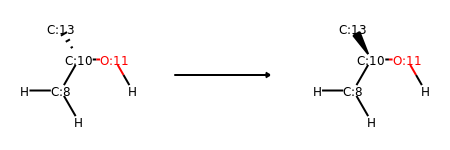

In [117]:
Chem.rdChemReactions.ReactionFromSmarts('[#6:8](-[#6@@:10](-[#8:11]-[H])-[#6:13])(-[H])-[H]>>[#6:8](-[#6@:10](-[#8:11]-[H])-[#6:13])(-[H])-[H]')

In [11]:
import scipy.io as sio
m = networkx.to_scipy_sparse_matrix(mmp._graph)
sio.mmwrite('test.mat', m)

NameError: name 'networkx' is not defined

In [ ]:
m

In [ ]:
np.array([45, 10, 39, 56, 1]) - 1

In [ ]:
[list(mmp._graph.nodes())[i] for i in np.array([45, 10, 39, 56, 1]) - 1]